# Diagnostic notebook for uncovering issues in raw input data before running the ETL pipeline

In [17]:
# Raw Data Profiling Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [18]:
# Set path to raw data file
data_path = Path("../data/raw/transactions.csv")
df = pd.read_csv(data_path, encoding="ISO-8859-1", low_memory=False)
df.columns = df.columns.str.strip()

In [19]:
# Basic Info
print("Raw DataFrame Info:")
df.info()


Raw DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525439 non-null  float64
 6   Customer ID  417541 non-null  object 
 7   Country      525430 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 32.1+ MB


In [20]:
# Summary Statistics
display(df.describe(include="all"))


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,525461,525461,522533,525461.000000,525461,525439.000000,417541,525430
unique,28816,4632,4681,NaN,25296,NaN,4384,41
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,12/06/2010 16:57,NaN,14911,United Kingdom
freq,675,3516,3549,NaN,675,NaN,5710,485741
mean,NaN,NaN,NaN,10.337667,NaN,4.688669,NaN,NaN
std,NaN,NaN,NaN,107.424110,NaN,146.130044,NaN,NaN
min,NaN,NaN,NaN,-9600.000000,NaN,-53594.360000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.100000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.210000,NaN,NaN


In [21]:
# Null Count
display(df.isnull().sum().sort_values(ascending=False))


Customer ID    107920
Description      2928
Country            31
Price              22
Quantity            0
StockCode           0
Invoice             0
InvoiceDate         0
dtype: int64

In [22]:
# Duplicate Checks
print(f"Total exact duplicates: {df.duplicated().sum()}")
duplicates_subset = df[df.duplicated(subset=["Invoice", "StockCode"], keep=False)]
print(f"Duplicate (Invoice, StockCode) rows: {duplicates_subset.shape[0]}")

Total exact duplicates: 6865
Duplicate (Invoice, StockCode) rows: 25399


In [23]:
# Suspicious Descriptions
suspicious = df["Description"].astype(str).str.strip().isin(["", "?", "UNKNOWN"])
print(f"Suspicious/Empty Descriptions: {suspicious.sum()}")

Suspicious/Empty Descriptions: 45


In [24]:
# Quantity/Price Issues
print(f"Quantity <= 0: {df[df['Quantity'] <= 0].shape[0]}")
print(f"Price <= 0: {df[df['Price'] <= 0].shape[0]}")
print(f"Quantity > 1000 (outliers): {df[df['Quantity'] > 1000].shape[0]}")
print(f"Price > 1000 (outliers): {df[df['Price'] > 1000].shape[0]}")

Quantity <= 0: 12326
Price <= 0: 3697
Quantity > 1000 (outliers): 236
Price > 1000 (outliers): 125


In [25]:
# InvoiceDate Checks
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
print(f"Min InvoiceDate: {df['InvoiceDate'].min()}")
print(f"Max InvoiceDate: {df['InvoiceDate'].max()}")
print(f"Missing/Invalid dates: {df['InvoiceDate'].isnull().sum()}")
print(f"Future dated invoices: {df[df['InvoiceDate'] > pd.Timestamp.now()].shape[0]}")

Min InvoiceDate: 2009-12-01 07:45:00
Max InvoiceDate: 2010-12-09 20:01:00
Missing/Invalid dates: 0
Future dated invoices: 0


In [26]:
# System StockCodes Check
system_codes = ["POST", "ADJUST", "CHECK"]
flagged = df["StockCode"].astype(str).str.upper().isin(system_codes)
print(f"System StockCodes (POST/ADJUST/CHECK): {flagged.sum()}")


System StockCodes (POST/ADJUST/CHECK): 932


In [27]:
# Multi-country Customers
multi_country = df.groupby("Customer ID")["Country"].nunique()
print(f"Customers appearing in >1 country: {multi_country[multi_country > 1].shape[0]}")

Customers appearing in >1 country: 5


In [28]:
# Unique Count Summary
summary_counts = {
    "Unique Invoices": df["Invoice"].nunique(),
    "Unique Customers": df["Customer ID"].nunique(),
    "Unique Products": df["StockCode"].nunique(),
    "Unique Countries": df["Country"].nunique()
}
display(summary_counts)


{'Unique Invoices': 28816,
 'Unique Customers': 4384,
 'Unique Products': 4632,
 'Unique Countries': 41}

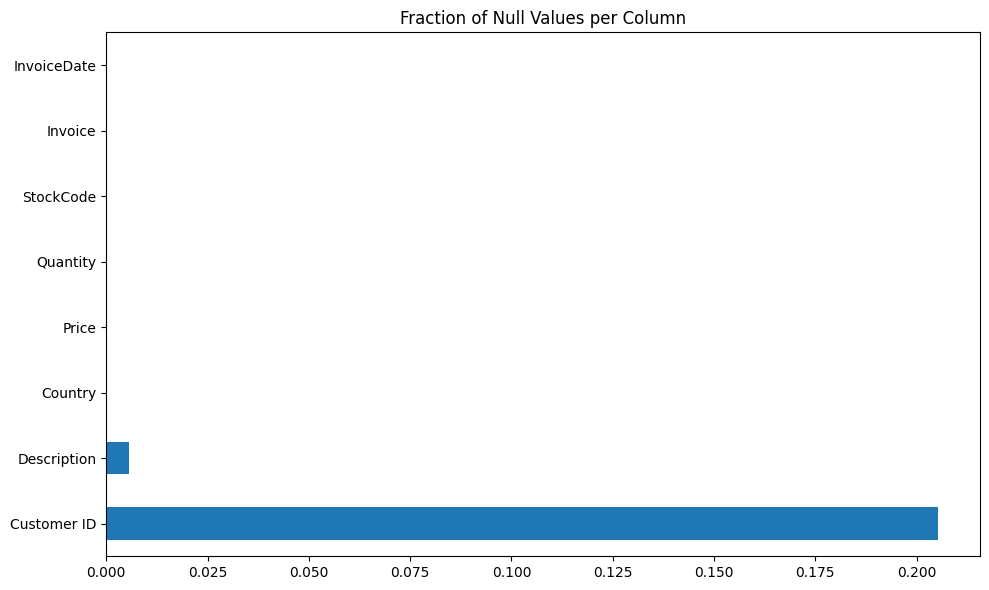

In [29]:
# Optional: Visualize Nulls and Distributions
plt.figure(figsize=(10, 6))
df.isnull().mean().sort_values(ascending=False).plot(kind='barh', title='Fraction of Null Values per Column')
plt.tight_layout()
plt.show()

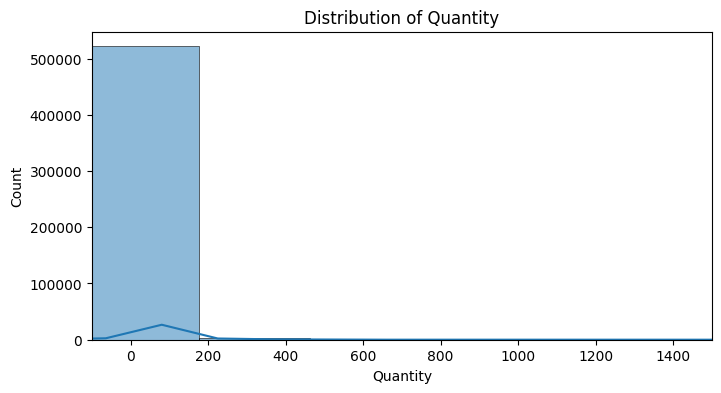

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Quantity'], bins=100, kde=True)
plt.title("Distribution of Quantity")
plt.xlim(-100, 1500)
plt.show()

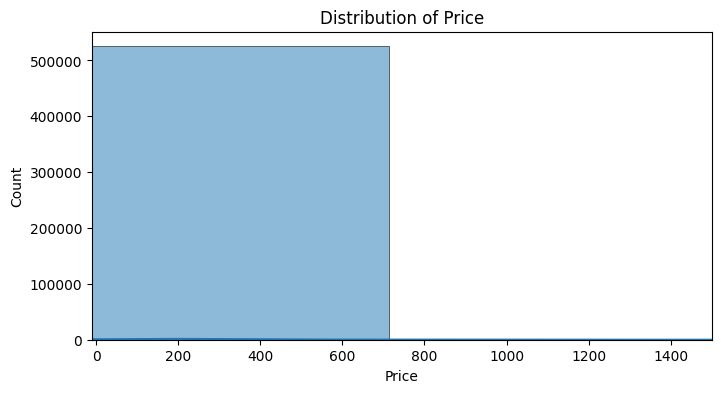

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Price'], bins=100, kde=True)
plt.title("Distribution of Price")
plt.xlim(-10, 1500)
plt.show()
